In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gneiss.sort import niche_sort
import seaborn as sns
from matplotlib import cm

from scipy.stats import skew
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Let's first add some code used to simulate band tables

In [2]:
def shift(l,n):
    sl = l
    table = [l]
    if n == 0:
        return table
    else:
        for k in range(n):
            sl = shift1(sl)
            table.append(sl)
        return table
def shift1(l):
    newlist = [0] * len(l)
    for i in range(1,len(l)):
        newlist[i] = l[i-1]
    return newlist    

Now, let's create a statistic to measure the strength of a band pattern.

Here, we will simplify measure the distance of a cell away from the diagonal, and weight that distance 
by the value in that cell.

In [3]:
def band_statistic(table):
    n, m = table.shape
    sse = 0
    for x in range(table.shape[0]):
        for y in range(table.shape[1]):
            sse += ((y - (n/m) * x) * table[x, y]) **2
    return sse

Let's create a really small table for demonstration.

In [4]:
n = 30  #otus 
band = 10 #band size
p = n - band + 1 #samples
y = [1./band]*band + [0]*(n-band)
table = shift(y,p-1)
table = np.column_stack(table)

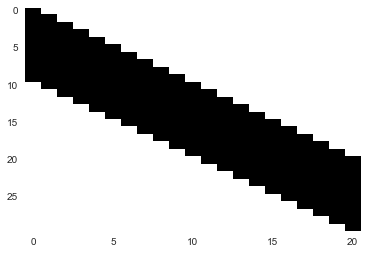

In [5]:
plt.imshow(table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [6]:
band_statistic(table)

290.57142857142878

In [7]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [8]:
band_statistic(niche_sort(table_df, gradient_s).values)

290.57142857142878

Ok, let's try to see what this will look like for random data.

In [9]:
random_table = pd.DataFrame(np.random.uniform(low=0.0, high=2.0, size=table.shape))
random_ph = pd.Series(np.random.uniform(low=0.0, high=1.0, size=table.shape[1]))
random_sorted_table = niche_sort(random_table, random_ph)

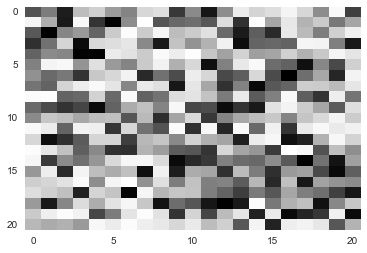

In [10]:
plt.imshow(random_sorted_table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [11]:
band_statistic(random_table.values)

230688.94322588673

Ok, so it looks like our simple statistic isn't complete crap.
Let's now try to formalize a permutation test.

Here, we will randomly permute values along the gradient, and `niche_sort` the table
according to values in this gradient.  We'll use the band statistic applied to these
scrambed/resorted tables to see how reliable the original statistic is.

In [12]:
"""
Only permutes the pH
"""
def band_permutation_test1(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _gradient = pd.Series(np.random.permutation(gradient_s),
                              index=gradient_s.index)
        _table = niche_sort(table, _gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [13]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [14]:
stat, pval, rstats = band_permutation_test1(table_df, gradient_s)

In [15]:
stat, pval

(290.57142857142878, 0.001)

Ok, what does the distribution of permuted band statistics look like?

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


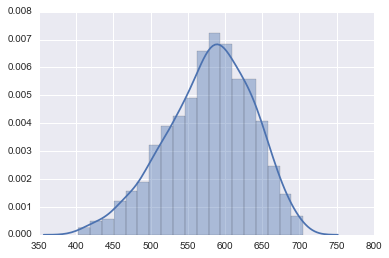

In [16]:
sns.distplot(rstats)

In [17]:
print('mean', rstats.mean())
print('variance', rstats.var())
print('skew', skew(rstats))

mean 578.622369308
variance 3361.04663917
skew -0.3955158466490613


It doesn't look normal.  Definitely is skewed towards the right.

But rather than permutating the labels of the gradient, what if we scramble all of the
values in the table?  We'll use a similar strategy as above.  But rather than
scrambling the gradient values, we'll scramble the table values, and `niche_sort` the table 
with respect to the gradient values.

In [18]:
"""
Completely scrambles elements within the table.
"""
def band_permutation_test2(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        vals = np.random.permutation(table.values.flatten())
        _table = pd.DataFrame(vals.reshape(table.shape[0], table.shape[1]),
                              index=table.index, columns=table.columns)    
        _table = niche_sort(_table, gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [19]:
stat, pval, rstats = band_permutation_test2(table_df, gradient_s)

In [20]:
stat, pval

(290.57142857142878, 0.001)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


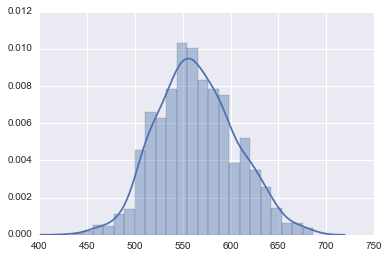

In [21]:
sns.distplot(rstats)

In [22]:
print('mean', rstats.mean())
print('variance', rstats.var())
print('skew', skew(rstats))

mean 564.524275091
variance 1713.39063102
skew 0.18804925869123917


Now this statistic seems to be skewed the opposite direction.  While these distributions are a little similar, 
the first distribution has a significantly larger mean than the second distribution.